# Imports

In [1]:
import os
os.chdir('../../vlm_toolbox/')

/home/alireza/vlm_toolbox


In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
import gc
import warnings

import pandas as pd
import torch
from matplotlib import pyplot as plt

from config.enums import ImageDatasets, Setups, Sources, Trainers
from config.path import EXPERIMENTS_MODEL_DIR
from config.setup import Setup
from metric.visualization.accuracy import plot_model_accuracy
from pipeline.pipeline import Pipeline

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings('ignore')

In [4]:
def flush():
    gc.collect()
    torch.cuda.empty_cache()

# Config

In [24]:
dataset_name = ImageDatasets.INATURALIST
hierarchy_levels_columns = ['phylum', 'class', 'order', 'family', 'genus', 'specific_epithet', 'default']
context_key_name = 'prompt_learner.ctx'

In [39]:
base_coop = Setup(
    dataset_name=ImageDatasets.INATURALIST,
    trainer_name=Trainers.COOP,
    setup_type=Setups.EVAL_ONLY,
    source=Sources.OPEN_AI,
    enable_novelty=True,
    annotations_key_value_criteria={'kingdom': ['Animalia']},
)
base_coop

Setup: (setup_type='eval_only', dataset_name='inaturalist2021', backbone_name='clip_vit_b_16', source='open_ai', trainer_name='coop', model_type='few_shot', annotations_key_value_criteria={'kingdom': ['Animalia']}, precision_dtype='fp16', main_metric_name='top_1', enable_novelty=True, use_dataset_context_init=False, eval_batch_size=1024, preprocess_batch_size=1024, m1_m2_id_same_granularity_level=False, eval_split='validation', top_k=5, random_state=42, is_soft=True, eval_full_precision=False, auto_batch_size=False)

In [40]:
contexts = {}
for col in hierarchy_levels_columns:
    level_setup = Setup(
        dataset_name=ImageDatasets.INATURALIST,
        trainer_name=Trainers.COOP,
        source=Sources.OPEN_AI,
        enable_novelty=True,
        label_column_name=col,
        annotations_key_value_criteria={'kingdom': ['Animalia']},
    )
    checkpoint_path = EXPERIMENTS_MODEL_DIR + level_setup.get_relative_save_path() + 'pytorch_model.bin'        
    level_context = torch.load(checkpoint_path)[context_key_name]
    contexts['col'] = level_context

### Device

In [33]:
DEVICE_TYPE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device(DEVICE_TYPE)
DEVICE

device(type='cuda')

# Evaluation

In [41]:
pipeline = Pipeline(base_coop, device_type=DEVICE_TYPE)

In [42]:
pipeline.setup_labels()

---------------------------
Labels Summary...
---------------------------

Current label column: name
Number of classes: 5388
Number of labels: 5388
Prompt mode: Soft
Soft prompt group: generic
Number of soft prompts: 1
Dataset's prompt context initialization: it is an image of

---------------------------
---------------------------



In [43]:
pipeline.setup_model()

Loading Model...
---------------------------

Initializing 1 prompt contexts randomely.
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

---------------------------
Model Summary...
---------------------------

coop - clip_vit_b_16
Total model parameters: 149628929
🔥 Trainable model parameters: 8192 (0.01%)
🧊 Frozen model parameters: 149620737 (99.99%)

Attribute Name: model, Type: CustomCLIP, Param Share: 100.00%:
-    Attribute Name: prompt_learner, Type: PromptLearner, Param Share: 0.01%:
--       🔥 Trainable: 100.00%, 🧊 Frozen: 0.00%
-    Attribute Name: image_encoder, Type: VisionTransformer, Param Share: 57.60%:
--       🔥 Trainable: 0.00%, 🧊 Frozen: 100.00%
-    Attribute Name: text_encoder, Type: TextEncoder, Param Share: 25.48%:
--       🔥 Trainable: 0.00%, 🧊 Frozen: 100.00%
-    Attribute Name: token_embedding, Type: Embedding, Param Share: 16.91%:
--       🔥 Trainable: 0.00%, 🧊 Frozen: 100.00%

Device: cuda:0
Model size: 979.266MB
Logi

In [44]:
pipeline.setup_data()

Loading Datasets...
---------------------------

m1 @ validation (image -> raw) Loaded.
m2 @ validation (text -> raw) Loaded.

---------------------------
Datasets Summary...
---------------------------



Filter (num_proc=2):   0%|          | 0/100000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/53880 [00:00<?, ? examples/s]

m1 @ validation (image -> embedding):
 Dataset({
    features: ['image_embeds', 'class_id'],
    num_rows: 53880
})

m2 @ validation (text -> raw):
 Dataset({
    features: ['label_id', 'label'],
    num_rows: 5388
})


---------------------------
---------------------------



In [99]:
pipeline.evaluate()

{'eval_loss': 8.298009872436523,
 'eval_top_1': 0.009187082405345211,
 'eval_top_2': 0.012193763919821826,
 'eval_top_3': 0.014458054936896808,
 'eval_top_4': 0.016369710467706012,
 'eval_top_5': 0.01766889383815887,
 'eval_runtime': 129.5678,
 'eval_samples_per_second': 415.844,
 'eval_steps_per_second': 0.409}

saved_dirs_dict = pipeline.save_metrics(main_metric_only=False)
print(saved_dirs_dict)

In [100]:
saved_dirs_dict = pipeline.save_metrics(main_metric_only=False)

In [101]:
main_metric_df = pd.read_csv(saved_dirs_dict['overall'])
main_metric_df

,accuracy,top_k,trainer_name
0,0.009187,1,coop
1,0.012194,2,coop
2,0.014458,3,coop
3,0.016370,4,coop
4,0.017669,5,coop


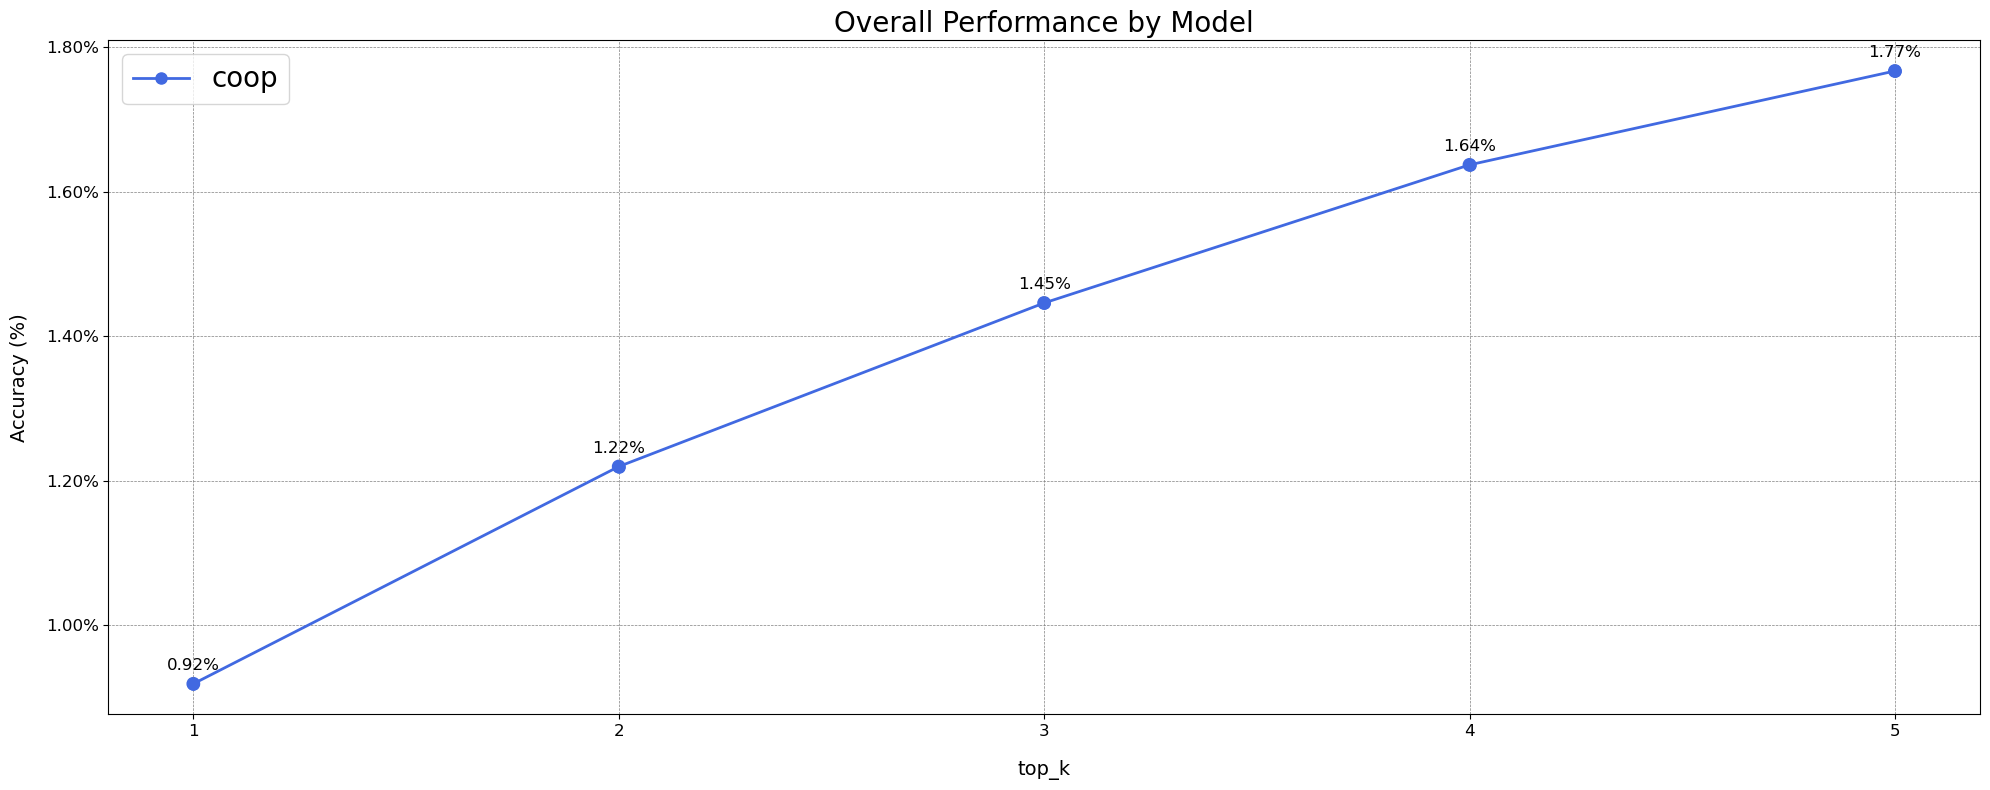

In [102]:
plot_model_accuracy(main_metric_df)
plt.show()